In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.core.dtypes.common import is_numeric_dtype
from sklearn.feature_selection import mutual_info_regression, SelectKBest
from sklearn.preprocessing import MinMaxScaler

In [2]:
DATA_FOLDER = 'dataset'
DATASET = os.path.join(DATA_FOLDER, 'outliers_removed.csv')

In [3]:
df = pd.read_csv(DATASET)

categorical_attr_list = [col for col in df.columns if not is_numeric_dtype(df[col])]

# one hot encoding
df_reg = df.drop(categorical_attr_list, axis=1)
df_reg = df_reg.join(pd.get_dummies(df[categorical_attr_list], columns=categorical_attr_list).astype(int))
df_reg.head()

,frame_count,sum,mean,std,min,max,q01,q05,q25,q75,...,actor_actor_24,actor_actor_3,actor_actor_4,actor_actor_5,actor_actor_6,actor_actor_7,actor_actor_8,actor_actor_9,sex_F,sex_M
0,160160,0.114319,7.137790e-07,0.004283,-0.042603,0.048157,-0.013550,-0.006104,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1
1,156956,0.149963,9.554485e-07,0.005084,-0.037018,0.058472,-0.015822,-0.007294,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,1
2,152152,0.139618,9.176213e-07,0.004886,-0.036652,0.062683,-0.014923,-0.006714,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1
3,169769,0.137665,8.108948e-07,0.002956,-0.026245,0.026215,-0.009399,-0.004364,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1
4,172972,0.140289,8.110521e-07,0.003085,-0.032349,0.028961,-0.008942,-0.004242,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
features_to_correct = ['stft_min', 'sc_min']
(df[features_to_correct] < 0).any()

stft_min    False
sc_min      False
dtype: bool

# stft_min

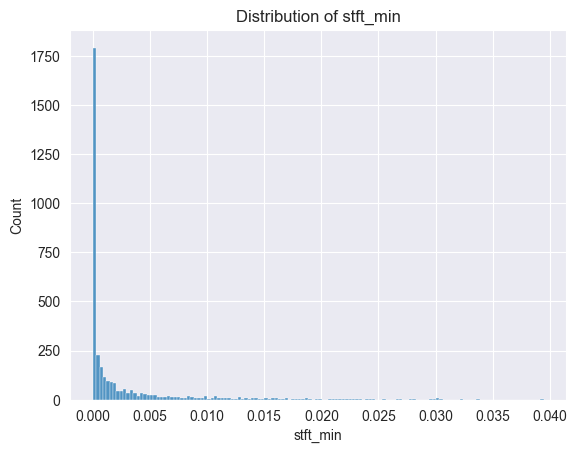

In [5]:
sns.histplot(data=df, x=df['stft_min'], stat='density')
plt.xlabel('stft_min')
plt.ylabel('Count')
plt.title('Distribution of stft_min')
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

# rows to be fixed, do not reset indexes!
df_zero = df_reg[df_reg['stft_min'] == 0]
df_nz = df_reg[df_reg['stft_min'] != 0].reset_index(drop=True)

# dataframe has been one hot encoded
split_index = df_nz.index[df_nz['actor_actor_19'] == 1][0]

df_train = df_nz[:split_index]
df_test = df_nz[split_index:]

df_train, df_valid = train_test_split(df_train, test_size=0.25, random_state=100)

y_train = np.log10(df_train['stft_min'].to_numpy())
y_valid = np.log10(df_valid['stft_min'].to_numpy())
y_test = np.log10(df_test['stft_min'].to_numpy())

df_zero = df_zero.drop(['stft_min'], axis=1)
df_train = df_train.drop(['stft_min'], axis=1)
df_valid = df_valid.drop(['stft_min'], axis=1)
df_test = df_test.drop(['stft_min'], axis=1)

X_to_pred = df_zero.to_numpy()
X_train = df_train.to_numpy()
X_valid = df_valid.to_numpy()
X_test = df_test.to_numpy()

print(X_train.shape, X_valid.shape, X_test.shape, X_to_pred.shape)

(793, 284) (265, 284) (362, 284) (1009, 284)


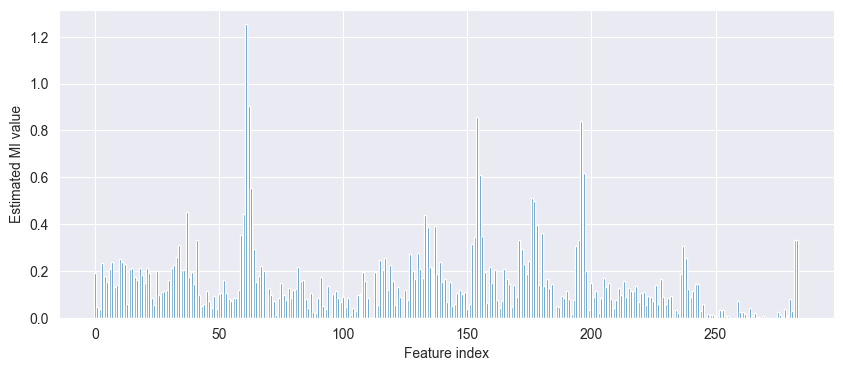

In [7]:
f_selector = SelectKBest(score_func=mutual_info_regression, k='all')
f_selector.fit(X_train, y_train)

plt.figure(figsize=(10, 4))
plt.bar([i for i in range(len(f_selector.scores_))], f_selector.scores_)
plt.xlabel('Feature index')
plt.ylabel('Estimated MI value')
plt.show()

In [8]:
f_selector = SelectKBest(score_func=mutual_info_regression, k=20)
f_selector.fit(X_train, y_train)

X_train = f_selector.transform(X_train)
X_valid = f_selector.transform(X_valid)
X_test = f_selector.transform(X_test)
X_to_pred = f_selector.transform(X_to_pred)

# selected columns
selected_indices = f_selector.get_support(indices=True)
df_reg.iloc[:, selected_indices]

,mfcc_q25,mfcc_q99,stft_mean,stft_std,stft_min,stft_q01,stft_q05,mfcc_q05_w2,mfcc_q25_w2,mfcc_q95_w2,stft_sum_w2,stft_std_w2,stft_q05_w2,stft_q25_w2,mfcc_q05_w3,mfcc_q25_w3,mfcc_q50_w3,mfcc_q95_w3,stft_std_w3,stft_q01_w3
0,-3.248759,165.340459,0.629568,0.277748,0.008878,0.048266,0.116556,-120.117107,-11.527863,52.003055,484.868805,0.293215,0.069133,0.261142,-67.755763,-9.989349,-0.172550,62.708651,0.290738,0.047669
1,-2.454553,175.846084,0.619984,0.279639,0.000000,0.039225,0.103585,-75.363458,-11.434454,48.559144,468.430938,0.302636,0.063778,0.239860,-71.935123,-9.649912,-0.237159,63.767483,0.285455,0.046734
2,-2.546799,165.640911,0.612607,0.263994,0.032363,0.058727,0.152042,-68.998278,-10.588931,47.860892,478.721360,0.293498,0.099196,0.268918,-69.634357,-8.167052,0.444741,63.596519,0.280918,0.049062
3,-3.493539,167.973568,0.608243,0.293414,0.000000,0.011911,0.097330,-83.044930,-10.651319,56.442131,480.684962,0.293618,0.074663,0.222230,-65.700882,-11.507271,-0.839454,69.896139,0.290291,0.046423
4,-2.329377,167.472222,0.644044,0.271359,0.000000,0.063752,0.148925,-73.239906,-10.560717,59.259329,527.873676,0.281825,0.085910,0.288242,-64.224837,-9.563899,0.129829,62.749889,0.274131,0.069192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2424,-14.566319,122.559663,0.380013,0.358211,0.000000,0.000000,0.000000,-99.759052,-20.961018,45.060317,392.845148,0.334506,0.000275,0.013865,-94.788390,-22.633643,-11.140555,56.190917,0.318587,0.000218
2425,-16.516638,108.475085,0.384475,0.342570,0.000000,0.000000,0.000535,-94.174167,-21.225479,49.527611,391.581885,0.327351,0.002639,0.026575,-129.524864,-25.793420,-12.820762,56.286695,0.319367,0.000418
2426,-15.071037,111.296732,0.379459,0.343235,0.000000,0.000000,0.000000,-95.961729,-21.014818,52.465301,387.840356,0.329636,0.005785,0.031443,-84.901732,-23.546573,-12.323875,55.225316,0.318763,0.000521
2427,-14.316145,113.483748,0.393004,0.353190,0.000000,0.000000,0.000000,-104.770460,-21.403561,51.408106,397.483970,0.340376,0.004331,0.028292,-84.443920,-23.132294,-10.467500,62.430943,0.321830,0.000820


In [9]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)
X_test = scaler.fit_transform(X_test)
X_to_pred = scaler.fit_transform(X_to_pred)

In [10]:
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import optuna

# objective function to be minimized
def objective_fun(trial):

    booster = trial.suggest_categorical('booster', ['gbtree', 'dart'])
    gamma = trial.suggest_float('gamma', 0, 5)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 3)
    subsample = trial.suggest_float('subsample', 0.4, 1)

    xgb = XGBRegressor(booster=booster, gamma=gamma, max_depth=max_depth, min_child_weight=min_child_weight, subsample=subsample)

    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_valid)

    error = mean_squared_error(y_valid, y_pred)

    return error


study = optuna.create_study()
study.optimize(objective_fun, n_trials=150, n_jobs=-1)

[I 2023-06-04 16:38:45,056] A new study created in memory with name: no-name-202c8976-3f68-4361-b441-8b791651eae8
[I 2023-06-04 16:38:49,734] Trial 0 finished with value: 0.054938922228540875 and parameters: {'booster': 'dart', 'gamma': 1.960299315742609, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.8247611200915452}. Best is trial 0 with value: 0.054938922228540875.
[I 2023-06-04 16:38:49,831] Trial 4 finished with value: 0.058648555244369946 and parameters: {'booster': 'dart', 'gamma': 0.41695944736450774, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.7094468535826581}. Best is trial 0 with value: 0.054938922228540875.
[I 2023-06-04 16:38:50,229] Trial 7 finished with value: 0.05659757837845611 and parameters: {'booster': 'gbtree', 'gamma': 1.0003635332484357, 'max_depth': 14, 'min_child_weight': 1, 'subsample': 0.9015847775449902}. Best is trial 0 with value: 0.054938922228540875.
[I 2023-06-04 16:38:50,265] Trial 6 finished with value: 0.06023698434771141 and param

In [11]:
best_params = study.best_params

xgb = XGBRegressor(**best_params)
xgb.fit(X_train, y_train)

y_pred_test = xgb.predict(X_test)

print(best_params)
print('Root mean squared error = %.4f' % np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('R-squared = %.4f' % r2_score(y_test, y_pred_test))

{'booster': 'dart', 'gamma': 1.422669799515667, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.6130381398080836}
Root mean squared error = 0.3045
R-squared = 0.7970


In [12]:
y_pred = xgb.predict(X_to_pred)
y_pred = np.power(10, y_pred)
y_pred

array([1.1736777e-02, 2.6076012e-03, 1.7623922e-02, ..., 5.4100765e-05,
       5.4100765e-05, 3.9794628e-05], dtype=float32)

In [13]:
# negative values predicted
np.count_nonzero(y_pred < 0)

0

In [14]:
df_zero['stft_min'] = y_pred
df.update(df_zero)

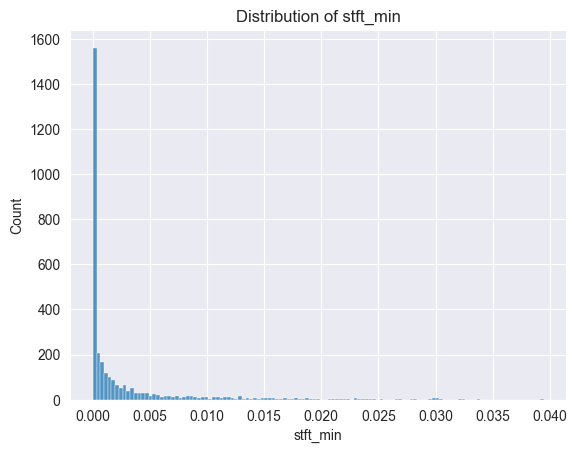

In [15]:
sns.histplot(data=df, x='stft_min', stat='density')
plt.xlabel('stft_min')
plt.ylabel('Count')
plt.title('Distribution of stft_min')
plt.show()

In [16]:
df['stft_min'].corr(df['stft_q01'], method='spearman')

0.9270518739282905

# frame_count

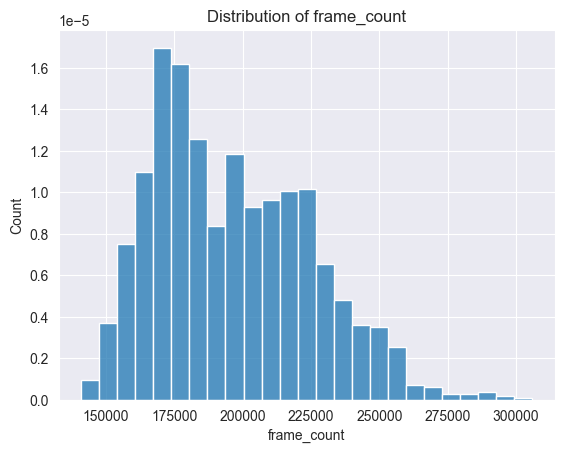

In [17]:
sns.histplot(data=df, x=df['frame_count'], stat='density')
plt.xlabel('frame_count')
plt.ylabel('Count')
plt.title('Distribution of frame_count')
plt.show()

In [18]:
from sklearn.model_selection import train_test_split

# dataframe has been one hot encoded
split_index = df_reg.index[df_reg['actor_actor_19'] == 1][0]

df_train = df_reg[:split_index]
df_test = df_reg[split_index:]

df_train, df_valid = train_test_split(df_train, test_size=0.25, random_state=100)

y_train = df_train['frame_count'].to_numpy()
y_valid = df_valid['frame_count'].to_numpy()
y_test = df_test['frame_count'].to_numpy()

df_train = df_train.drop(['frame_count'], axis=1)
df_valid = df_valid.drop(['frame_count'], axis=1)
df_test = df_test.drop(['frame_count'], axis=1)

X_train = df_train.to_numpy()
X_valid = df_valid.to_numpy()
X_test = df_test.to_numpy()

print(X_train.shape, X_valid.shape, X_test.shape)

(1357, 284) (453, 284) (619, 284)


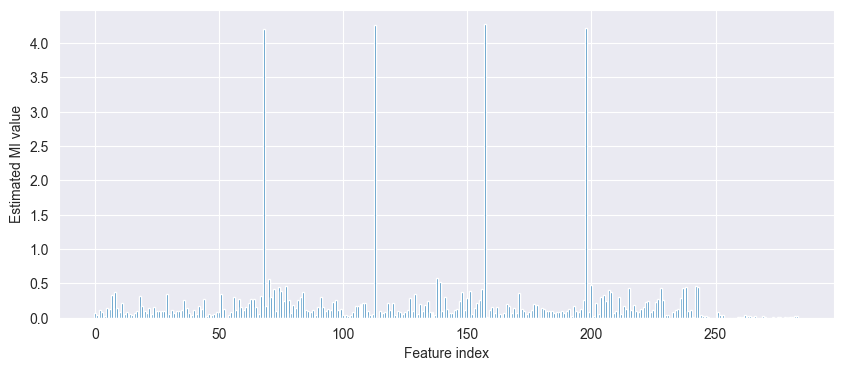

In [19]:
f_selector = SelectKBest(score_func=mutual_info_regression, k='all')
f_selector.fit(X_train, y_train)

plt.figure(figsize=(10, 4))
plt.bar([i for i in range(len(f_selector.scores_))], f_selector.scores_)
plt.xlabel('Feature index')
plt.ylabel('Estimated MI value')
plt.show()

In [20]:
f_selector = SelectKBest(score_func=mutual_info_regression, k=4)
f_selector.fit(X_train, y_train)

X_train = f_selector.transform(X_train)
X_valid = f_selector.transform(X_valid)
X_test = f_selector.transform(X_test)

# selected columns
selected_indices = f_selector.get_support(indices=True)
df_reg.iloc[:, selected_indices]

,stft_skew,stft_skew_w1,stft_skew_w2,stft_q25_w3
0,-0.492174,-0.561529,0.155481,0.209817
1,-0.473775,-0.280715,0.128863,0.221506
2,-0.269943,-0.205140,0.096396,0.295453
3,-0.414662,-1.838410,0.303969,0.189045
4,-0.457552,-0.729845,0.164317,0.257204
...,...,...,...,...
2424,0.411823,0.320232,0.936319,0.009999
2425,0.460356,0.154591,0.940912,0.010816
2426,0.506281,0.107261,0.879905,0.009420
2427,0.375856,0.201044,0.769979,0.012667


In [21]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)
X_test = scaler.fit_transform(X_test)

In [22]:
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import optuna

# objective function to be minimized
def objective_fun(trial):

    booster = trial.suggest_categorical('booster', ['gbtree', 'dart'])
    gamma = trial.suggest_float('gamma', 0, 5)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 3)
    subsample = trial.suggest_float('subsample', 0.4, 1)

    xgb = XGBRegressor(booster=booster, gamma=gamma, max_depth=max_depth, min_child_weight=min_child_weight, subsample=subsample)

    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_valid)

    error = mean_squared_error(y_valid, y_pred)

    return error


study = optuna.create_study()
study.optimize(objective_fun, n_trials=150, n_jobs=-1)

[I 2023-06-04 16:39:49,276] A new study created in memory with name: no-name-3573fd46-e005-4680-b2a2-174a976ee821
[I 2023-06-04 16:39:49,938] Trial 1 finished with value: 7632778.43263659 and parameters: {'booster': 'gbtree', 'gamma': 2.5649731088141374, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.7354804083150712}. Best is trial 1 with value: 7632778.43263659.
[I 2023-06-04 16:39:50,449] Trial 7 finished with value: 7598105.277857901 and parameters: {'booster': 'gbtree', 'gamma': 3.148519391529364, 'max_depth': 11, 'min_child_weight': 1, 'subsample': 0.5305765453335871}. Best is trial 7 with value: 7598105.277857901.
[I 2023-06-04 16:39:51,147] Trial 0 finished with value: 7566152.011760787 and parameters: {'booster': 'gbtree', 'gamma': 1.842183154441695, 'max_depth': 18, 'min_child_weight': 1, 'subsample': 0.6383221876682283}. Best is trial 0 with value: 7566152.011760787.
[I 2023-06-04 16:39:51,181] Trial 2 finished with value: 7604272.300679929 and parameters: {'booster':

In [23]:
best_params = study.best_params

xgb = XGBRegressor(**best_params)
xgb.fit(X_train, y_train)

y_pred_test = xgb.predict(X_test)

print(best_params)
print('Root mean squared error = %.4f' % np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('R-squared = %.4f' % r2_score(y_test, y_pred_test))

{'booster': 'dart', 'gamma': 0.8199863830436156, 'max_depth': 19, 'min_child_weight': 1, 'subsample': 0.5369020152431427}
Root mean squared error = 9281.2573
R-squared = 0.8963


In [24]:
pd.DataFrame({'test' : y_test, 'pred': y_pred_test})

,test,pred
0,161762,155354.906250
1,155355,148948.984375
2,160160,153753.203125
3,158558,152152.281250
4,176176,168168.031250
...,...,...
614,219419,209809.437500
615,217817,208207.843750
616,206606,196997.078125
617,203404,193793.953125


In [27]:
from keras.layers import Dense
from keras import Input, Model

# objective function to be minimized
def objective_fun(trial):

    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'elu'])
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'rmsprop', 'adagrad'])
    loss = trial.suggest_categorical('loss', ['mean_squared_error'])
    units = trial.suggest_int('units', 32, 64, step=32)
    epochs = trial.suggest_int('epochs', 3, 7)
    batch_size = trial.suggest_int('batch_size', 64, 128, step=64)


    input_layer = Input(shape=(X_train.shape[1]), name='input')
    hidden_layer = Dense(units=units, activation=activation)(input_layer)
    #hidden_layer = Dense(units=units, activation=activation)(hidden_layer)
    output_layer = Dense(1, name='output')(hidden_layer)

    ann = Model(inputs=input_layer, outputs=output_layer, name='DenseNetwork')

    ann.compile(optimizer=optimizer, loss=loss)

    ann.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=False)

    y_pred = ann.predict(X_valid)

    error = mean_squared_error(y_valid, y_pred)

    return error


study = optuna.create_study()
study.optimize(objective_fun, n_trials=150, n_jobs=-1)

[I 2023-06-04 16:51:36,334] A new study created in memory with name: no-name-8528a4e8-f5e1-4f20-a779-688ad6858413


 6/15 [===========>..................] - ETA: 0s

[I 2023-06-04 16:51:37,506] Trial 4 finished with value: 39037813059.73816 and parameters: {'activation': 'elu', 'optimizer': 'adagrad', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 3, 'batch_size': 128}. Best is trial 4 with value: 39037813059.73816.


 1/15 [=>............................] - ETA: 0s

[I 2023-06-04 16:51:37,582] Trial 5 finished with value: 39037919647.14098 and parameters: {'activation': 'elu', 'optimizer': 'adagrad', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 3, 'batch_size': 128}. Best is trial 4 with value: 39037813059.73816.


15/15 [==============================] - 0s 6ms/step


[I 2023-06-04 16:51:37,688] Trial 0 finished with value: 39037283081.30689 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 5, 'batch_size': 128}. Best is trial 0 with value: 39037283081.30689.
[I 2023-06-04 16:51:37,693] Trial 1 finished with value: 39037673255.29984 and parameters: {'activation': 'relu', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 4, 'batch_size': 128}. Best is trial 0 with value: 39037283081.30689.


 1/15 [=>............................] - ETA: 0s

[I 2023-06-04 16:51:37,696] Trial 3 finished with value: 39037758002.414276 and parameters: {'activation': 'relu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 3, 'batch_size': 64}. Best is trial 0 with value: 39037283081.30689.
[I 2023-06-04 16:51:37,736] Trial 7 finished with value: 39037535410.148056 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 6, 'batch_size': 128}. Best is trial 0 with value: 39037283081.30689.


15/15 [==============================] - 0s 11ms/step


[I 2023-06-04 16:51:38,029] Trial 2 finished with value: 39037147898.14954 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 4, 'batch_size': 64}. Best is trial 2 with value: 39037147898.14954.


15/15 [==============================] - 0s 13ms/step


[I 2023-06-04 16:51:38,502] Trial 6 finished with value: 39037052402.41663 and parameters: {'activation': 'tanh', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 5, 'batch_size': 64}. Best is trial 6 with value: 39037052402.41663.


15/15 [==============================] - 0s 5ms/step


[I 2023-06-04 16:51:38,896] Trial 11 finished with value: 39037614812.01067 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 3, 'batch_size': 128}. Best is trial 6 with value: 39037052402.41663.


15/15 [==============================] - 0s 2ms/step


[I 2023-06-04 16:51:39,119] Trial 13 finished with value: 39037765100.66655 and parameters: {'activation': 'relu', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 4, 'batch_size': 128}. Best is trial 6 with value: 39037052402.41663.


15/15 [==============================] - 0s 4ms/step


[I 2023-06-04 16:51:39,267] Trial 14 finished with value: 39037410430.12853 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 4, 'batch_size': 128}. Best is trial 6 with value: 39037052402.41663.


15/15 [==============================] - 0s 9ms/step


[I 2023-06-04 16:51:39,518] Trial 10 finished with value: 39036870404.95145 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 5, 'batch_size': 64}. Best is trial 10 with value: 39036870404.95145.


 7/15 [=============>................] - ETA: 0s

[I 2023-06-04 16:51:39,651] Trial 8 finished with value: 39036299858.517624 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 7, 'batch_size': 64}. Best is trial 8 with value: 39036299858.517624.


12/15 [=======================>......] - ETA: 0s

[I 2023-06-04 16:51:39,657] Trial 9 finished with value: 39037946614.69201 and parameters: {'activation': 'relu', 'optimizer': 'adagrad', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 6, 'batch_size': 128}. Best is trial 8 with value: 39036299858.517624.


 8/15 [===============>..............] - ETA: 0s

[I 2023-06-04 16:51:39,818] Trial 12 finished with value: 39036222731.82742 and parameters: {'activation': 'elu', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 7, 'batch_size': 64}. Best is trial 12 with value: 39036222731.82742.


15/15 [==============================] - 0s 13ms/step


[I 2023-06-04 16:51:40,058] Trial 15 finished with value: 39037282223.48274 and parameters: {'activation': 'tanh', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 7, 'batch_size': 128}. Best is trial 12 with value: 39036222731.82742.


15/15 [==============================] - 0s 5ms/step


[I 2023-06-04 16:51:40,483] Trial 16 finished with value: 39037708483.0904 and parameters: {'activation': 'relu', 'optimizer': 'adagrad', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 6, 'batch_size': 64}. Best is trial 12 with value: 39036222731.82742.


15/15 [==============================] - 0s 5ms/step


[I 2023-06-04 16:51:40,761] Trial 17 finished with value: 39036026648.4738 and parameters: {'activation': 'tanh', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 7, 'batch_size': 64}. Best is trial 17 with value: 39036026648.4738.


 1/15 [=>............................] - ETA: 0s

[I 2023-06-04 16:51:41,012] Trial 18 finished with value: 39036159396.03445 and parameters: {'activation': 'tanh', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 7, 'batch_size': 64}. Best is trial 17 with value: 39036026648.4738.


15/15 [==============================] - 0s 5ms/step


[I 2023-06-04 16:51:41,141] Trial 20 finished with value: 39035953864.80378 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 7, 'batch_size': 64}. Best is trial 20 with value: 39035953864.80378.
[I 2023-06-04 16:51:41,155] Trial 21 finished with value: 39036321414.97144 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 7, 'batch_size': 64}. Best is trial 20 with value: 39035953864.80378.
[I 2023-06-04 16:51:41,156] Trial 19 finished with value: 39035880771.76335 and parameters: {'activation': 'tanh', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 7, 'batch_size': 64}. Best is trial 19 with value: 39035880771.76335.
[I 2023-06-04 16:51:41,244] Trial 22 finished with value: 39036092170.732635 and parameters: {'activation': 'tanh', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 7, 'batch_size': 64}. Best 

15/15 [==============================] - 0s 21ms/step


[I 2023-06-04 16:51:41,840] Trial 23 finished with value: 39035897502.218666 and parameters: {'activation': 'tanh', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 7, 'batch_size': 64}. Best is trial 19 with value: 39035880771.76335.


15/15 [==============================] - 0s 3ms/step


[I 2023-06-04 16:51:42,130] Trial 24 finished with value: 39036418319.56958 and parameters: {'activation': 'tanh', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 7, 'batch_size': 64}. Best is trial 19 with value: 39035880771.76335.


 1/15 [=>............................] - ETA: 0s

[I 2023-06-04 16:51:42,585] Trial 25 finished with value: 39036350490.779915 and parameters: {'activation': 'tanh', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 7, 'batch_size': 64}. Best is trial 19 with value: 39035880771.76335.


15/15 [==============================] - 0s 7ms/step


[I 2023-06-04 16:51:42,593] Trial 29 finished with value: 39036415677.713455 and parameters: {'activation': 'tanh', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 6, 'batch_size': 64}. Best is trial 19 with value: 39035880771.76335.


15/15 [==============================] - 0s 6ms/step


[I 2023-06-04 16:51:42,677] Trial 28 finished with value: 39036257102.02174 and parameters: {'activation': 'tanh', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 6, 'batch_size': 64}. Best is trial 19 with value: 39035880771.76335.


 8/15 [===============>..............] - ETA: 0s

[I 2023-06-04 16:51:42,680] Trial 26 finished with value: 39036110217.45214 and parameters: {'activation': 'tanh', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 7, 'batch_size': 64}. Best is trial 19 with value: 39035880771.76335.
[I 2023-06-04 16:51:42,740] Trial 27 finished with value: 39036683328.582405 and parameters: {'activation': 'tanh', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 6, 'batch_size': 64}. Best is trial 19 with value: 39035880771.76335.


15/15 [==============================] - 0s 11ms/step


[I 2023-06-04 16:51:43,073] Trial 30 finished with value: 39036361116.74846 and parameters: {'activation': 'tanh', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 6, 'batch_size': 64}. Best is trial 19 with value: 39035880771.76335.


15/15 [==============================] - 0s 10ms/step


[I 2023-06-04 16:51:43,456] Trial 31 finished with value: 39036450811.492905 and parameters: {'activation': 'tanh', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 6, 'batch_size': 64}. Best is trial 19 with value: 39035880771.76335.


15/15 [==============================] - 0s 6ms/step


[I 2023-06-04 16:51:43,745] Trial 32 finished with value: 39036821697.296394 and parameters: {'activation': 'tanh', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 6, 'batch_size': 64}. Best is trial 19 with value: 39035880771.76335.


15/15 [==============================] - 0s 3ms/step


[I 2023-06-04 16:51:44,219] Trial 36 finished with value: 39037891930.39315 and parameters: {'activation': 'tanh', 'optimizer': 'adagrad', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 5, 'batch_size': 64}. Best is trial 19 with value: 39035880771.76335.


15/15 [==============================] - 0s 3ms/step


[I 2023-06-04 16:51:44,249] Trial 33 finished with value: 39036572450.565636 and parameters: {'activation': 'tanh', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 6, 'batch_size': 64}. Best is trial 19 with value: 39035880771.76335.


15/15 [==============================] - 0s 3ms/step


[I 2023-06-04 16:51:44,290] Trial 34 finished with value: 39036555495.978065 and parameters: {'activation': 'tanh', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 6, 'batch_size': 64}. Best is trial 19 with value: 39035880771.76335.
[I 2023-06-04 16:51:44,368] Trial 37 finished with value: 39037843638.381294 and parameters: {'activation': 'tanh', 'optimizer': 'adagrad', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 5, 'batch_size': 64}. Best is trial 19 with value: 39035880771.76335.


15/15 [==============================] - 0s 6ms/step


[I 2023-06-04 16:51:44,843] Trial 38 finished with value: 39036244332.84221 and parameters: {'activation': 'tanh', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 7, 'batch_size': 64}. Best is trial 19 with value: 39035880771.76335.


 1/15 [=>............................] - ETA: 0s

[I 2023-06-04 16:51:44,873] Trial 35 finished with value: 39037985342.540405 and parameters: {'activation': 'tanh', 'optimizer': 'adagrad', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 5, 'batch_size': 64}. Best is trial 19 with value: 39035880771.76335.


15/15 [==============================] - 0s 4ms/step


[I 2023-06-04 16:51:44,971] Trial 39 finished with value: 39036029523.68913 and parameters: {'activation': 'tanh', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 7, 'batch_size': 64}. Best is trial 19 with value: 39035880771.76335.


15/15 [==============================] - 0s 8ms/step


[I 2023-06-04 16:51:45,299] Trial 40 finished with value: 39036288302.47405 and parameters: {'activation': 'tanh', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 7, 'batch_size': 64}. Best is trial 19 with value: 39035880771.76335.


 9/15 [=================>............] - ETA: 0s

[I 2023-06-04 16:51:45,735] Trial 41 finished with value: 39036305006.85063 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 7, 'batch_size': 64}. Best is trial 19 with value: 39035880771.76335.


15/15 [==============================] - 0s 6ms/step


[I 2023-06-04 16:51:45,784] Trial 42 finished with value: 39036005012.107544 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 7, 'batch_size': 64}. Best is trial 19 with value: 39035880771.76335.


 1/15 [=>............................] - ETA: 0s

[I 2023-06-04 16:51:45,817] Trial 43 finished with value: 39036181696.15351 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 7, 'batch_size': 64}. Best is trial 19 with value: 39035880771.76335.


15/15 [==============================] - 0s 3ms/step


[I 2023-06-04 16:51:45,916] Trial 44 finished with value: 39036973910.06666 and parameters: {'activation': 'relu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 7, 'batch_size': 64}. Best is trial 19 with value: 39035880771.76335.


15/15 [==============================] - 0s 6ms/step


[I 2023-06-04 16:51:46,328] Trial 46 finished with value: 39036901973.251274 and parameters: {'activation': 'relu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 7, 'batch_size': 64}. Best is trial 19 with value: 39035880771.76335.
[I 2023-06-04 16:51:46,423] Trial 45 finished with value: 39037414790.464836 and parameters: {'activation': 'relu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 7, 'batch_size': 64}. Best is trial 19 with value: 39035880771.76335.


15/15 [==============================] - 0s 6ms/step


[I 2023-06-04 16:51:46,627] Trial 47 finished with value: 39036910272.72502 and parameters: {'activation': 'relu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 7, 'batch_size': 64}. Best is trial 19 with value: 39035880771.76335.


15/15 [==============================] - 0s 5ms/step


[I 2023-06-04 16:51:46,815] Trial 48 finished with value: 39037392955.10006 and parameters: {'activation': 'relu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 7, 'batch_size': 64}. Best is trial 19 with value: 39035880771.76335.


 9/15 [=================>............] - ETA: 0s

[I 2023-06-04 16:51:47,433] Trial 49 finished with value: 39037447186.8786 and parameters: {'activation': 'relu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 7, 'batch_size': 64}. Best is trial 19 with value: 39035880771.76335.
[I 2023-06-04 16:51:47,447] Trial 50 finished with value: 39037132590.2466 and parameters: {'activation': 'relu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 7, 'batch_size': 64}. Best is trial 19 with value: 39035880771.76335.


15/15 [==============================] - 0s 15ms/step


[I 2023-06-04 16:51:47,537] Trial 51 finished with value: 39036558305.47331 and parameters: {'activation': 'relu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 7, 'batch_size': 64}. Best is trial 19 with value: 39035880771.76335.


15/15 [==============================] - 0s 6ms/step


[I 2023-06-04 16:51:47,711] Trial 52 finished with value: 39037420949.09031 and parameters: {'activation': 'relu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 32, 'epochs': 7, 'batch_size': 64}. Best is trial 19 with value: 39035880771.76335.


15/15 [==============================] - 0s 8ms/step


[I 2023-06-04 16:51:48,152] Trial 53 finished with value: 39034767995.54603 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 53 with value: 39034767995.54603.


 7/15 [=============>................] - ETA: 0s

[I 2023-06-04 16:51:48,320] Trial 56 finished with value: 39036764325.6802 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 128}. Best is trial 53 with value: 39034767995.54603.


12/15 [=======================>......] - ETA: 0s

[I 2023-06-04 16:51:48,383] Trial 57 finished with value: 39037454954.37355 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 4, 'batch_size': 128}. Best is trial 53 with value: 39034767995.54603.


15/15 [==============================] - 0s 5ms/step


[I 2023-06-04 16:51:48,466] Trial 55 finished with value: 39034797696.275665 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 53 with value: 39034767995.54603.


15/15 [==============================] - 0s 9ms/step


[I 2023-06-04 16:51:48,783] Trial 54 finished with value: 39034781439.39241 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 53 with value: 39034767995.54603.


15/15 [==============================] - 0s 7ms/step


[I 2023-06-04 16:51:49,202] Trial 61 finished with value: 39037449889.8116 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 4, 'batch_size': 128}. Best is trial 53 with value: 39034767995.54603.
[I 2023-06-04 16:51:49,212] Trial 58 finished with value: 39035010092.39487 and parameters: {'activation': 'tanh', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 53 with value: 39034767995.54603.
[I 2023-06-04 16:51:49,234] Trial 59 finished with value: 39034629299.917496 and parameters: {'activation': 'tanh', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 59 with value: 39034629299.917496.


15/15 [==============================] - 0s 4ms/step


[I 2023-06-04 16:51:49,463] Trial 60 finished with value: 39035035075.76237 and parameters: {'activation': 'tanh', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 59 with value: 39034629299.917496.


10/15 [===================>..........] - ETA: 0s

[I 2023-06-04 16:51:50,014] Trial 65 finished with value: 39037059748.4685 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 3, 'batch_size': 64}. Best is trial 59 with value: 39034629299.917496.


15/15 [==============================] - 0s 8ms/step


[I 2023-06-04 16:51:50,081] Trial 63 finished with value: 39035470339.678604 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 6, 'batch_size': 64}. Best is trial 59 with value: 39034629299.917496.
[I 2023-06-04 16:51:50,091] Trial 62 finished with value: 39034911597.08532 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 59 with value: 39034629299.917496.
[I 2023-06-04 16:51:50,174] Trial 64 finished with value: 39035653266.24425 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 6, 'batch_size': 64}. Best is trial 59 with value: 39034629299.917496.


 1/15 [=>............................] - ETA: 0s

[I 2023-06-04 16:51:50,595] Trial 66 finished with value: 39037752232.79377 and parameters: {'activation': 'elu', 'optimizer': 'adagrad', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 3, 'batch_size': 64}. Best is trial 59 with value: 39034629299.917496.


 1/15 [=>............................] - ETA: 0s

[I 2023-06-04 16:51:50,790] Trial 68 finished with value: 39036934871.61412 and parameters: {'activation': 'elu', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 3, 'batch_size': 64}. Best is trial 59 with value: 39034629299.917496.


15/15 [==============================] - 0s 5ms/step


[I 2023-06-04 16:51:50,892] Trial 67 finished with value: 39037632840.02464 and parameters: {'activation': 'elu', 'optimizer': 'adagrad', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 6, 'batch_size': 64}. Best is trial 59 with value: 39034629299.917496.


15/15 [==============================] - 0s 10ms/step


[I 2023-06-04 16:51:51,399] Trial 69 finished with value: 39035051609.07019 and parameters: {'activation': 'elu', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 59 with value: 39034629299.917496.


15/15 [==============================] - 0s 3ms/step


[I 2023-06-04 16:51:51,578] Trial 70 finished with value: 39035851223.35553 and parameters: {'activation': 'elu', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 6, 'batch_size': 64}. Best is trial 59 with value: 39034629299.917496.
[I 2023-06-04 16:51:51,586] Trial 72 finished with value: 39037612168.426216 and parameters: {'activation': 'elu', 'optimizer': 'adagrad', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 59 with value: 39034629299.917496.


 1/15 [=>............................] - ETA: 0s

[I 2023-06-04 16:51:51,639] Trial 71 finished with value: 39035600373.244095 and parameters: {'activation': 'elu', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 6, 'batch_size': 64}. Best is trial 59 with value: 39034629299.917496.


15/15 [==============================] - 0s 3ms/step


[I 2023-06-04 16:51:51,889] Trial 73 finished with value: 39037666944.0894 and parameters: {'activation': 'elu', 'optimizer': 'adagrad', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 59 with value: 39034629299.917496.


15/15 [==============================] - 0s 6ms/step


[I 2023-06-04 16:51:52,414] Trial 74 finished with value: 39035147464.98651 and parameters: {'activation': 'tanh', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 59 with value: 39034629299.917496.


15/15 [==============================] - 0s 6ms/step


[I 2023-06-04 16:51:52,754] Trial 76 finished with value: 39034894679.94924 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 59 with value: 39034629299.917496.


15/15 [==============================] - 0s 3ms/step


[I 2023-06-04 16:51:53,056] Trial 75 finished with value: 39034827388.4565 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 59 with value: 39034629299.917496.
[I 2023-06-04 16:51:53,074] Trial 77 finished with value: 39034664615.911285 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 59 with value: 39034629299.917496.


 1/15 [=>............................] - ETA: 0s

[I 2023-06-04 16:51:53,249] Trial 79 finished with value: 39034689282.00105 and parameters: {'activation': 'tanh', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 59 with value: 39034629299.917496.
[I 2023-06-04 16:51:53,292] Trial 78 finished with value: 39034589302.56874 and parameters: {'activation': 'tanh', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 78 with value: 39034589302.56874.


 1/15 [=>............................] - ETA: 0s

[I 2023-06-04 16:51:53,456] Trial 80 finished with value: 39034781061.237236 and parameters: {'activation': 'tanh', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 78 with value: 39034589302.56874.


15/15 [==============================] - 0s 3ms/step


[I 2023-06-04 16:51:53,574] Trial 81 finished with value: 39035008384.30297 and parameters: {'activation': 'tanh', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 78 with value: 39034589302.56874.


15/15 [==============================] - 0s 7ms/step


[I 2023-06-04 16:51:54,094] Trial 82 finished with value: 39035028974.954025 and parameters: {'activation': 'tanh', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 78 with value: 39034589302.56874.


15/15 [==============================] - 0s 3ms/step


[I 2023-06-04 16:51:54,425] Trial 83 finished with value: 39034793943.50542 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 78 with value: 39034589302.56874.


15/15 [==============================] - 0s 4ms/step


[I 2023-06-04 16:51:54,672] Trial 85 finished with value: 39034825272.836586 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 78 with value: 39034589302.56874.


15/15 [==============================] - 0s 4ms/step


[I 2023-06-04 16:51:54,721] Trial 84 finished with value: 39034611828.58398 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 78 with value: 39034589302.56874.


 1/15 [=>............................] - ETA: 0s

[I 2023-06-04 16:51:54,765] Trial 86 finished with value: 39034637854.11315 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 78 with value: 39034589302.56874.


15/15 [==============================] - 0s 5ms/step


[I 2023-06-04 16:51:54,904] Trial 87 finished with value: 39035016322.41079 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 78 with value: 39034589302.56874.


15/15 [==============================] - 0s 7ms/step


[I 2023-06-04 16:51:55,088] Trial 88 finished with value: 39035044183.67243 and parameters: {'activation': 'tanh', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 78 with value: 39034589302.56874.
[I 2023-06-04 16:51:55,109] Trial 89 finished with value: 39034614254.85402 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 78 with value: 39034589302.56874.


15/15 [==============================] - 0s 8ms/step


[I 2023-06-04 16:51:55,592] Trial 90 finished with value: 39034677403.8148 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 78 with value: 39034589302.56874.


15/15 [==============================] - 0s 17ms/step


[I 2023-06-04 16:51:56,314] Trial 91 finished with value: 39034403774.58884 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.


15/15 [==============================] - 0s 3ms/step


[I 2023-06-04 16:51:56,466] Trial 94 finished with value: 39034777139.79604 and parameters: {'activation': 'tanh', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.
[I 2023-06-04 16:51:56,475] Trial 92 finished with value: 39035267404.33135 and parameters: {'activation': 'tanh', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.
[I 2023-06-04 16:51:56,499] Trial 93 finished with value: 39034776333.15921 and parameters: {'activation': 'tanh', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.


15/15 [==============================] - 0s 2ms/step


[I 2023-06-04 16:51:56,621] Trial 95 finished with value: 39034983962.33896 and parameters: {'activation': 'tanh', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.


15/15 [==============================] - 0s 10ms/step


[I 2023-06-04 16:51:56,957] Trial 97 finished with value: 39034913210.5331 and parameters: {'activation': 'tanh', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.
[I 2023-06-04 16:51:56,959] Trial 96 finished with value: 39034808101.745575 and parameters: {'activation': 'tanh', 'optimizer': 'rmsprop', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.


15/15 [==============================] - 0s 2ms/step


[I 2023-06-04 16:51:57,714] Trial 98 finished with value: 39034808697.10303 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.


15/15 [==============================] - 0s 3ms/step


[I 2023-06-04 16:51:57,855] Trial 99 finished with value: 39034914272.84565 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.


15/15 [==============================] - ETA: 0s

[I 2023-06-04 16:51:58,004] Trial 101 finished with value: 39034418289.05331 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.


15/15 [==============================] - 0s 4ms/step


[I 2023-06-04 16:51:58,008] Trial 100 finished with value: 39034608183.020164 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.
[I 2023-06-04 16:51:58,020] Trial 103 finished with value: 39034679290.85647 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.
[I 2023-06-04 16:51:58,119] Trial 102 finished with value: 39035147423.13254 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.


15/15 [==============================] - 0s 15ms/step


[I 2023-06-04 16:51:58,565] Trial 105 finished with value: 39034827547.34746 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.
[I 2023-06-04 16:51:58,666] Trial 104 finished with value: 39034509957.39027 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.


15/15 [==============================] - 0s 2ms/step


[I 2023-06-04 16:51:59,266] Trial 106 finished with value: 39034750534.80236 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.


15/15 [==============================] - 0s 3ms/step


[I 2023-06-04 16:51:59,384] Trial 107 finished with value: 39034725509.30067 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.


 1/15 [=>............................] - ETA: 0s

[I 2023-06-04 16:51:59,487] Trial 110 finished with value: 39034919327.14617 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.


12/15 [=======================>......] - ETA: 0s

[I 2023-06-04 16:51:59,580] Trial 108 finished with value: 39034903445.32304 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.


15/15 [==============================] - 0s 5ms/step


[I 2023-06-04 16:51:59,604] Trial 109 finished with value: 39035073929.53372 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.
[I 2023-06-04 16:51:59,682] Trial 111 finished with value: 39034718728.95133 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.


15/15 [==============================] - 0s 6ms/step


[I 2023-06-04 16:51:59,976] Trial 112 finished with value: 39035001199.661125 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.


15/15 [==============================] - 0s 11ms/step


[I 2023-06-04 16:52:00,292] Trial 113 finished with value: 39035116848.175064 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.


 1/15 [=>............................] - ETA: 0s

[I 2023-06-04 16:52:00,955] Trial 114 finished with value: 39034967890.3884 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.


 1/15 [=>............................] - ETA: 0s

[I 2023-06-04 16:52:01,122] Trial 115 finished with value: 39034737456.75528 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.


15/15 [==============================] - 0s 5ms/step


[I 2023-06-04 16:52:01,225] Trial 116 finished with value: 39035121593.92222 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.


 1/15 [=>............................] - ETA: 0s

[I 2023-06-04 16:52:01,266] Trial 118 finished with value: 39034812133.3289 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.


15/15 [==============================] - 0s 5ms/step


[I 2023-06-04 16:52:01,355] Trial 117 finished with value: 39034921086.08004 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.
[I 2023-06-04 16:52:01,417] Trial 119 finished with value: 39034898163.24241 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.


15/15 [==============================] - 0s 10ms/step


[I 2023-06-04 16:52:02,026] Trial 121 finished with value: 39035059771.90498 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.


15/15 [==============================] - 0s 3ms/step


[I 2023-06-04 16:52:02,239] Trial 120 finished with value: 39034778498.23734 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.


15/15 [==============================] - ETA: 0s

[I 2023-06-04 16:52:02,580] Trial 122 finished with value: 39034916796.541275 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.


 1/15 [=>............................] - ETA: 0s

[I 2023-06-04 16:52:02,696] Trial 123 finished with value: 39034768117.173256 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.


 1/15 [=>............................] - ETA: 0s

[I 2023-06-04 16:52:02,829] Trial 124 finished with value: 39034900905.92913 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.
[I 2023-06-04 16:52:02,837] Trial 126 finished with value: 39034783946.61814 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.


15/15 [==============================] - 0s 4ms/step


[I 2023-06-04 16:52:02,868] Trial 125 finished with value: 39034702295.9279 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.
[I 2023-06-04 16:52:02,948] Trial 127 finished with value: 39035564887.95271 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 6, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.


15/15 [==============================] - 0s 10ms/step


[I 2023-06-04 16:52:03,636] Trial 128 finished with value: 39034817605.04583 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.


15/15 [==============================] - 0s 2ms/step


[I 2023-06-04 16:52:03,780] Trial 129 finished with value: 39035264314.91524 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.


 7/15 [=============>................] - ETA: 0s

[I 2023-06-04 16:52:04,072] Trial 131 finished with value: 39036262829.96221 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 5, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.


12/15 [=======================>......] - ETA: 0s

[I 2023-06-04 16:52:04,253] Trial 133 finished with value: 39036070484.903786 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 5, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.
[I 2023-06-04 16:52:04,284] Trial 132 finished with value: 39036064495.36723 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 5, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.


15/15 [==============================] - 0s 11ms/step


[I 2023-06-04 16:52:04,391] Trial 135 finished with value: 39036820968.58154 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 128}. Best is trial 91 with value: 39034403774.58884.


15/15 [==============================] - 0s 16ms/step


[I 2023-06-04 16:52:04,556] Trial 134 finished with value: 39036050613.6305 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 5, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.
[I 2023-06-04 16:52:04,557] Trial 130 finished with value: 39034798772.8255 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.


15/15 [==============================] - 0s 2ms/step


[I 2023-06-04 16:52:05,444] Trial 137 finished with value: 39037979116.42179 and parameters: {'activation': 'tanh', 'optimizer': 'adagrad', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 5, 'batch_size': 128}. Best is trial 91 with value: 39034403774.58884.
[I 2023-06-04 16:52:05,446] Trial 136 finished with value: 39036971148.48056 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 128}. Best is trial 91 with value: 39034403774.58884.


15/15 [==============================] - 0s 7ms/step


[I 2023-06-04 16:52:06,009] Trial 138 finished with value: 39034809109.38684 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.


 1/15 [=>............................] - ETA: 0s

[I 2023-06-04 16:52:06,022] Trial 139 finished with value: 39034788994.6886 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.


15/15 [==============================] - 0s 2ms/step


[I 2023-06-04 16:52:06,138] Trial 140 finished with value: 39035079574.2668 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.


13/15 [=========================>....] - ETA: 0s

[I 2023-06-04 16:52:06,199] Trial 141 finished with value: 39034865192.591835 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.


15/15 [==============================] - 0s 6ms/step


[I 2023-06-04 16:52:06,298] Trial 142 finished with value: 39037765537.858505 and parameters: {'activation': 'tanh', 'optimizer': 'adagrad', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.


15/15 [==============================] - 0s 3ms/step


[I 2023-06-04 16:52:06,855] Trial 143 finished with value: 39037616411.30629 and parameters: {'activation': 'tanh', 'optimizer': 'adagrad', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.
[I 2023-06-04 16:52:06,856] Trial 144 finished with value: 39034717590.59966 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.


15/15 [==============================] - 0s 2ms/step


[I 2023-06-04 16:52:06,883] Trial 145 finished with value: 39034648476.875046 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.


 1/15 [=>............................] - ETA: 0s

[I 2023-06-04 16:52:07,040] Trial 146 finished with value: 39034655397.118225 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.
[I 2023-06-04 16:52:07,045] Trial 147 finished with value: 39034976313.001205 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.


15/15 [==============================] - 0s 798us/step


[I 2023-06-04 16:52:07,051] Trial 148 finished with value: 39034990231.35803 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.


15/15 [==============================] - 0s 340us/step


[I 2023-06-04 16:52:07,071] Trial 149 finished with value: 39034703261.14115 and parameters: {'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}. Best is trial 91 with value: 39034403774.58884.


In [28]:
best_params = study.best_params

input_layer = Input(shape=(X_train.shape[1]), name='input')
hidden_layer = Dense(units=best_params['units'], activation=best_params['activation'])(input_layer)
hidden_layer = Dense(units=best_params['units'], activation=best_params['activation'])(hidden_layer)
output_layer = Dense(1, name='output')(hidden_layer)

ann = Model(inputs=input_layer, outputs=output_layer, name='DenseNetwork')

ann.compile(optimizer=best_params['optimizer'], loss=best_params['loss'])

ann.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'])

y_pred_test = ann.predict(X_test)

print(best_params)
print('Root mean squared error = %.4f' % np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('R-squared = %.4f' % r2_score(y_test, y_pred_test))

Epoch 1/7
22/22 [==============================] - 0s 597us/step - loss: 38506500096.0000
Epoch 2/7
22/22 [==============================] - 0s 512us/step - loss: 38505140224.0000
Epoch 3/7
22/22 [==============================] - 0s 537us/step - loss: 38503305216.0000
Epoch 4/7
22/22 [==============================] - 0s 503us/step - loss: 38501666816.0000
Epoch 5/7
22/22 [==============================] - 0s 515us/step - loss: 38500458496.0000
Epoch 6/7
22/22 [==============================] - 0s 469us/step - loss: 38499520512.0000
Epoch 7/7
20/20 [==============================] - 0s 357us/step
{'activation': 'tanh', 'optimizer': 'adam', 'loss': 'mean_squared_error', 'units': 64, 'epochs': 7, 'batch_size': 64}
Root mean squared error = 203771.5994
R-squared = -48.9711
